In [1]:
# General libraries
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Utils functions
from utils.utils import kfold, read_datasets, plot_pred_expected_results

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
folds = kfold()

In [4]:
# Specify range of hyperparameters to tune
# hyper_params = {
#     'hidden_layer_sizes': [(80,), (100,), (110,), (150,)],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'solver': ['lbfgs', 'sgd', 'adam'],
#     'alpha': [0.0001, 0.1],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'learning_rate_init': [0.001, 0.002, 0.005, 0.006],
#     'power_t': [0.5, 0.6],
#     'max_iter': [200],
#     'shuffle': [True],
#     'momentum': [0.5, 0.8, 0.9, 1],
#     'early_stopping': [False]

# }

hyper_params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.005],
    'power_t': [0.6],
    'max_iter': [200],
    'shuffle': [True],
    'momentum': [0.8],
    'early_stopping': [False]

}

# Call RandomSearchCV()
model_cv = RandomizedSearchCV(
    estimator = MLPRegressor(),
    param_distributions = hyper_params,
    n_iter=300,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'solver': 'sgd', 'shuffle': True, 'power_t': 0.6, 'momentum': 0.8, 'max_iter': 200, 'learning_rate_init': 0.005, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'early_stopping': False, 'alpha': 0.0001, 'activation': 'tanh'}


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [5]:
# Create new model with best_params_ from grid search

mlp_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Test Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.2652356839593467, 0.20836885311776765, 0.23310460302081726, 0.2482745094393427, 0.25596987901389956, 0.28374104938798395, 0.25611720504950675, 0.27722705736987463, 0.271330479194814, 0.2492701713638079]
Test Results: [0.2494389969475418, 0.0048850311740110675, 0.2845278799789627, 0.2629212102198, 0.2692912157371292, -0.32456841502138656, 0.17064956046939395, 0.12191548806893127, 0.09994798080228273, 0.209914835984636]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.25486394909171606
Train std: 0.021036831790770823
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.13489237843613022
Validation std: 0.1750053505610733


In [8]:
y_pred = mlp_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1167


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


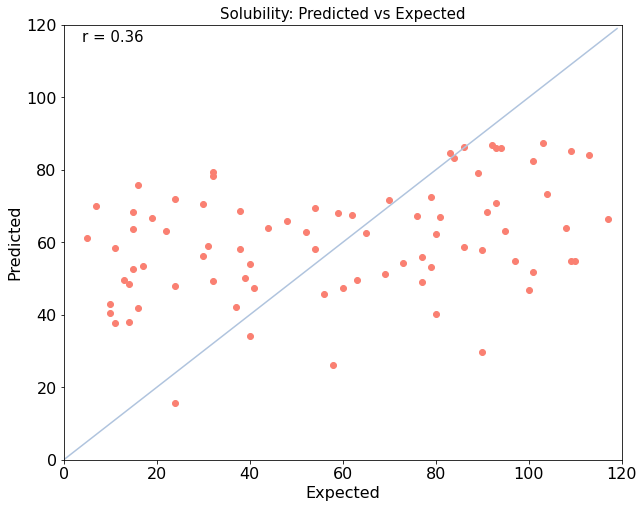

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/mlpRegressor_model.joblib'
joblib.dump(mlp_best, filename)

['../models/mlpRegressor_model.joblib']